---

<div align="center"><h1>Hackaton: Fundamentos de Programação Paralela</h1></div>
<div align="center"><h1>-Aplicação de técnicas de paralelismo para otimização de código-</h1></div>


---


Fernando Antonio Marques Schettini $^1$, Gabriel Mascarenhas Costa de Sousa $^2$, Jadson Nobre das Virgens $^2$

$^1$ Curso de Engenharia de Computação - Centro universitário SENAI CIMATEC, Salvador, Bahia, Brazil;  

$^2$ Curso de Sistemas de Informação - Universidade do Estado da Bahia, Salvador, Bahia, Brazil.

## Introdução

<font style='font-family:"Times New Roman"'>
<div style="text-align: justify">
&emsp;Este Hackaton tem como objetivo simular uma situação real para otimização de código, onde o grupo trabalhará em um código previamente estabelecido e através de diferentes técnicas e ferramentas de paralelização tentará alcançar uma melhor performance. Desta forma, este notebook é o produto final do Hackaton proposto, ele fará parte da avaliação dos discentes autores dentro da disciplina de Fundamentos de Programação Paralela, lecionada pelo docente Murilo Boratto, no segundo semestre de 2022. Dentro deste notebook, está documentado todo o processo de paralelização de código, a equipe utilizou as bibliotecas OpenMP, MPI e CUDA dentro do código para implementação das técnicas de paralelização e paradigmas de
programação vistas em sala de aula:
<br>

1. Multicore;
2. Multiprocess;
3. Modelo Híbrido entre Multicore e Multiprocess; 
4. Programação em GPU (Host to device).

&emsp;Como prova de conceito e atividade desse Hackaton, foi nos apresentado um código sequencial para a quebra de senha de até vinte caracteres utilizando bruteforce, onde o código busca, através de tentativa e erro, encontrar a senha passada como parâmetro, assim, simulando situações reais de quebra de senha por força bruta. Nosso objetivo é encontrar a melhor forma de agilizar o processo dessa quebra de senha, utilizando os conceitos estudados ao longo do semestre, citados acima. Para isso, primeiramente será realizado um profilling para análize do custo computacional das funções do código e posteriormente faremos a aplicação das quatro técnicas citadas acima para a otimização do código. Uma vez que as implementações utilizando cada técnica estejam funcionando, formularemos scripts para encontrar os parâmetros ótimos para cada uma, aprimorando ainda mais o processo e nos permitindo avaliar melhor os ganhos e perdas de cada implementação. No fim, apresentaremos uma análise dos tempos de execução de cada técnica junto aos respectivos speed-ups, comparando-os à execução sequencial do programa.

&emsp;<b>OBS: Caso esteja executando estes códigos dentro de um supercomputador, para execução desses códigos deve-se carregar os modúlos necessários. Para isso, execute o seguinte comando antes de iniciar o jupyter notebook:</b>
</div>
</font>

In [ ]:
!module load openmpi/4.1.1-cuda-11.6-ofed-5.4 anaconda3/2020.07

<font style='font-family:"Times New Roman"'>
<div style="text-align: justify">

&emsp;<b>Caso esteja executando estes códigos pelo colab, então execute os seguintes comandos para preparar o ambiente:</b>
</div>
</font>

In [ ]:
%%shell
apt-get install bc
apt-get install openmpi-bin openmpi-common libopenmpi-dev libgtk2.0-dev
apt-get install libomp-dev gcc

---

## O Código Sequencial - Brute Force

```cpp
#include <stdio.h>
#include <stdlib.h>
#include <string.h>
#include <time.h>
#include <math.h>

//97 to 122 use only lowercase letters
//65 to 90 use only capital letters
//48 to 57 use only numbers
#define START_CHAR 48
#define END_CHAR 122
#define MAXIMUM_PASSWORD 20

void bruteForce(char *pass);
long long my_pow(long long x, int y);

void printTime(char *text, double time){ //funcao para printar o tempo em arquivo texto, no final da execução
  FILE *f = fopen("seq_time.txt", "a"); //abre o arquivo 
  fprintf(f, "%s %1.2f\n", text, time);
  fclose(f); //fecha o arquivo
}

int main(int argc, char **argv) {
  time_t t1, t2;
  double dif;
  time (&t1); // Captura tempo no começo do processo de brute force
  bruteForce(argv[1]);
  time (&t2); // Captura tempo no começo do processo de brute force

  dif = difftime (t2,t1); //Calcula tempo de execução baseado em t1 e t2
  printf("\n%1.2f seconds\n", dif);
  printTime(argv[1], dif);
  return 0;
}

void bruteForce(char *pass) {
  int size = strlen(pass);
  int pass_b26[size];
  long long int j;
  long long int pass_decimal = 0;
  int base = END_CHAR-START_CHAR+2;
  time_t t1, t2;
  double dif;

  //printf("base: %d\n", base);
  printf("Estamos tentando quebrar: %s\n", pass);

  time (&t1);
  //"Convertendo" a senha para base 26, pegando seu correspondente de 1 a base original baseado na ordem do alfabeto.
  for(int i = 0; i < size; i++){
    pass_b26[i] = (int)pass[i]-START_CHAR+1; //Calculo para transformação
    //printf(" %d\n", pass_b26[i]);
  } 

  time (&t2);
  dif = difftime (t2,t1);
  printf("\nEste é o tempo do primeiro loop: %1.2f segundos\n", dif);

  time (&t1);
  //Convertendo a senha para um numero em base 10
  for(int i = size - 1; i > -1; i--){
    pass_decimal += (long long int) pass_b26[i]*my_pow(base,i);
    //printf("pass decimal: %lld\n", pass_decimal);
  }
  time (&t2);
  dif = difftime (t2,t1);
  printf("\nEste é o tempo do segundo loop: %1.2f segundos\n", dif);

  long long int max = my_pow(base,size); //Em tese, o tamanho maximo do numero do numero resultante da conversão da senha para base original
  char s[size];

  time (&t1);
  //Laco que compara cada numero com a senha na base 10, caso encontre a senha é transformada novamente para base 26 e exibida na tela, encerrando o programa. 
  for(j = 0; j < max; j++){
    if(j == pass_decimal){ //achou a senha
      printf("Encontrou o password!\n");
      int index = 0;

      printf("O número que estamos tentando encontrar (password na base decimal): %lli\n", j);
      while(j > 0){ //transformando o numero encontrado para base original
        s[index++] = START_CHAR + j%base-1;
        j /= base;
      }
      s[index] = '\0';
      printf("Password encontrado: %s\n", s);
      break;
    }
  }
  time (&t2);
  dif = difftime (t2,t1);
  printf("\nEste é o tempo do terceiro loop: %1.2f segundos\n", dif);
}

//Funcao recursiva para calculo de potencia
long long my_pow(long long x, int y)
{
  long long res = 1;
  if (y==0)
    return res;
  else
    return x*my_pow(x,y-1);
}
```

In [ ]:
#@title Escrever bruteforce.c
%%writefile bruteforce.c
#include <stdio.h>
#include <stdlib.h>
#include <string.h>
#include <time.h>
#include <math.h>

//97 to 122 use only lowercase letters
//65 to 90 use only capital letters
//48 to 57 use only numbers
#define START_CHAR 48
#define END_CHAR 122
#define MAXIMUM_PASSWORD 20

void bruteForce(char *pass);
long long my_pow(long long x, int y);

void printTime(char *text, double time){ //funcao para printar o tempo em arquivo texto, no final da execução
  FILE *f = fopen("seq_time.txt", "a"); //abre o arquivo 
  fprintf(f, "%s %1.2f\n", text, time);
  fclose(f); //fecha o arquivo
}

int main(int argc, char **argv) {
  time_t t1, t2;
  double dif;
  time (&t1); // Captura tempo no começo do processo de brute force
  bruteForce(argv[1]);
  time (&t2); // Captura tempo no começo do processo de brute force

  dif = difftime (t2,t1); //Calcula tempo de execução baseado em t1 e t2
  printf("\n%1.2f seconds\n", dif);
  printTime(argv[1], dif);
  return 0;
}

void bruteForce(char *pass) {
  int size = strlen(pass);
  int pass_b26[size];
  long long int j;
  long long int pass_decimal = 0;
  int base = END_CHAR-START_CHAR+2;
  time_t t1, t2;
  double dif;

  //printf("base: %d\n", base);
  printf("Estamos tentando quebrar: %s\n", pass);

  time (&t1);
  //"Convertendo" a senha para base 26, pegando seu correspondente de 1 a base original baseado na ordem do alfabeto.
  for(int i = 0; i < size; i++){
    pass_b26[i] = (int)pass[i]-START_CHAR+1; //Calculo para transformação
    //printf(" %d\n", pass_b26[i]);
  } 

  time (&t2);
  dif = difftime (t2,t1);
  printf("\nEste é o tempo do primeiro loop: %1.2f segundos\n", dif);

  time (&t1);
  //Convertendo a senha para um numero em base 10
  for(int i = size - 1; i > -1; i--){
    pass_decimal += (long long int) pass_b26[i]*my_pow(base,i);
    //printf("pass decimal: %lld\n", pass_decimal);
  }
  time (&t2);
  dif = difftime (t2,t1);
  printf("\nEste é o tempo do segundo loop: %1.2f segundos\n", dif);

  long long int max = my_pow(base,size); //Em tese, o tamanho maximo do numero do numero resultante da conversão da senha para base original
  char s[size];

  time (&t1);
  //Laco que compara cada numero com a senha na base 10, caso encontre a senha é transformada novamente para base 26 e exibida na tela, encerrando o programa. 
  for(j = 0; j < max; j++){
    if(j == pass_decimal){ //achou a senha
      printf("Encontrou o password!\n");
      int index = 0;

      printf("O número que estamos tentando encontrar (password na base decimal): %lli\n", j);
      while(j > 0){ //transformando o numero encontrado para base original
        s[index++] = START_CHAR + j%base-1;
        j /= base;
      }
      s[index] = '\0';
      printf("Password encontrado: %s\n", s);
      break;
    }
  }
  time (&t2);
  dif = difftime (t2,t1);
  printf("\nEste é o tempo do terceiro loop: %1.2f segundos\n", dif);
}

//Funcao recursiva para calculo de potencia
long long my_pow(long long x, int y)
{
  long long res = 1;
  if (y==0)
    return res;
  else
    return x*my_pow(x,y-1);
}

Writing bruteforce.c


<font style='font-family:"Times New Roman"'>
<div style="text-align: justify">

&emsp;O código acima tem a finalidade de simular quebra de senhas, através da estrátegia de força bruta, ou seja, teste de possbilidades uma a uma. Perceba que o número de possibilidades em um alfabeto de 26 letras minúsculas em uma senha de 20 caracteres é enorme, por isso, tentar cada combinação exige um poder computacional gigante e demora muito tempo, especialmente para um código sequencial.<br>  &emsp;Primeiramente, o algoritmo realiza a leitura de uma string qualquer passada como parâmetro pelo terminal, respeitando os limites pré-estabelecidos, e a transforma em sua representação numérica de inteiro. Um vetor de inteiros é criado para armazena-la, letra por letra, transformando os valores de acordo com a posição das letras na tabela ASCII em relação ao caractere inicial de referência. Dessa forma, levando em conta, por exemplo, apenas letras minúsculas, a letra "a" se torna "1", "b" se torna "2" e assim por diante. Logo depois, tratando esse vetor de inteiros como um número em base 26 em ele é "encriptado" em um novo inteiro de base númerica 10, o que pode gerar um valor extremamente alto que cresce exponencialmente a cada letra da palavra. Este processo é representado pela figura 1.

**OBS: tudo descrito acima vale para o código com _range_ para letras minúsculas, case o espaço amostral muda, a base de conversão muda também mas a lógica permanece.
</div>
</font>

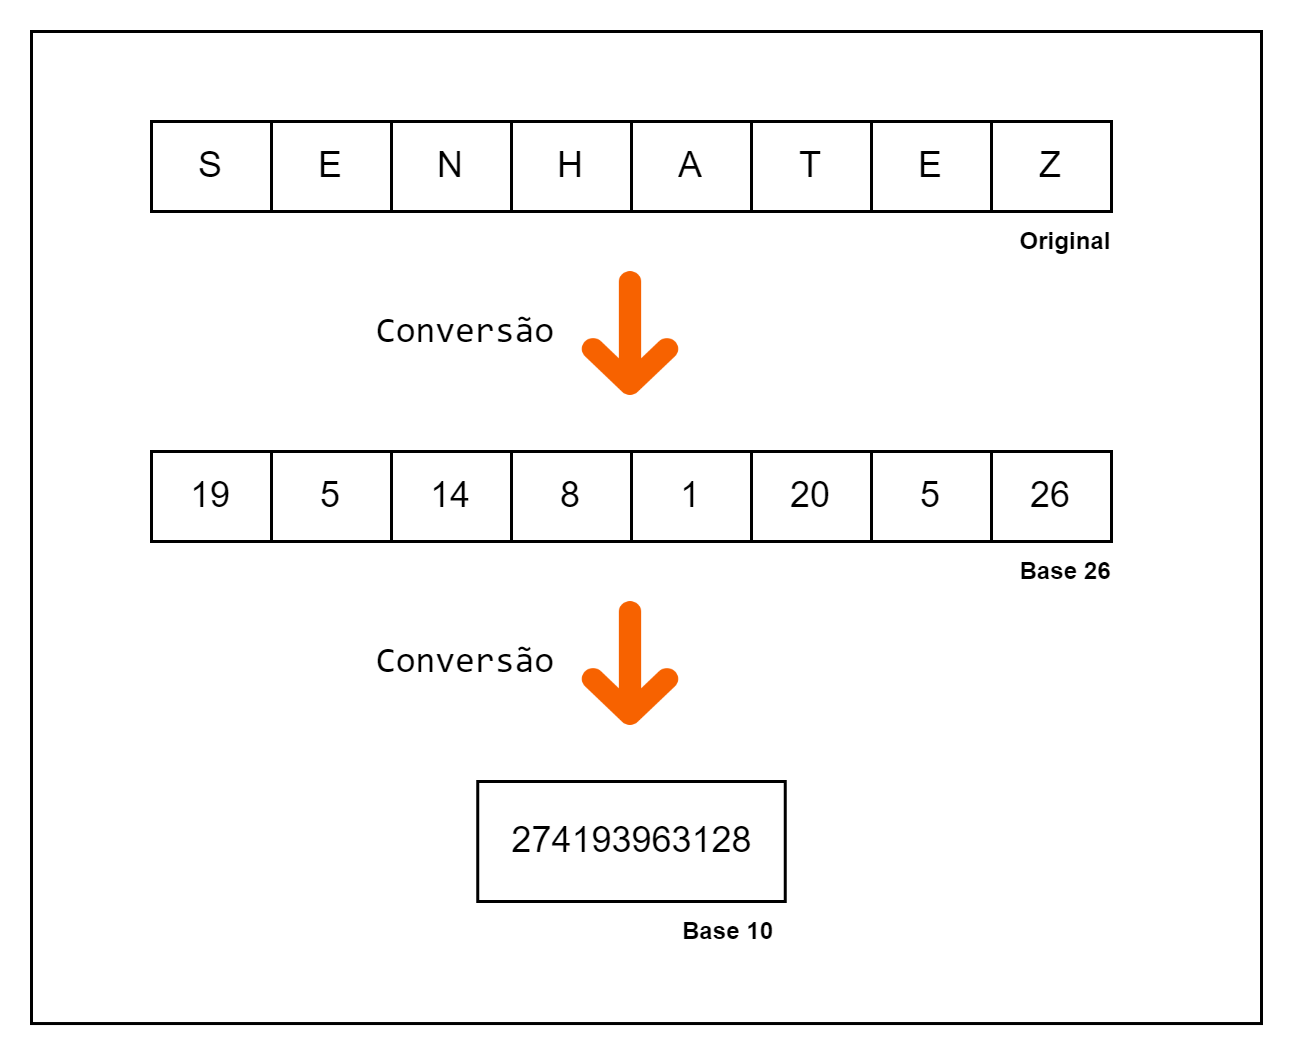

<font style='font-family:"Times New Roman"'>
<div style="text-align: justify"></center>
<div align="center"><b>Figura 1 -</b> Processos de transformação da senha até sua representação em decimal.</div>
</div>
</font>

<font style='font-family:"Times New Roman"'>
<div style="text-align: justify">

&emsp;Só a partir desse ponto a técnica de força bruta entra em ação para efetivamente decriptar a senha, comparando número a número dentro do laço _for_. Quando a senha é encontrada ela é transformada novamente na string original como representado pela figura 2, então o processo se encerra, exibindo o tempo total de execução do código.<br>
&emsp;Códigos que utilizam métodos de força bruta são exemplos clássicos para implementação de técnicas de paralelização, devido a necessidade de um poder computacional muito grande e independêcia entre as tentativas de comparação entre combinações, a implementação de técnicas como essas podem aumentar a eficiência do código de forma brutal. 

**OBS: Por questões de padronização dentro do Hackaton, utilizaremos a senha "senhatez" para a realização dos experimentos. Também utilizaremos a versão C99 da linguagem para execução dos testes.

</div>
</font>

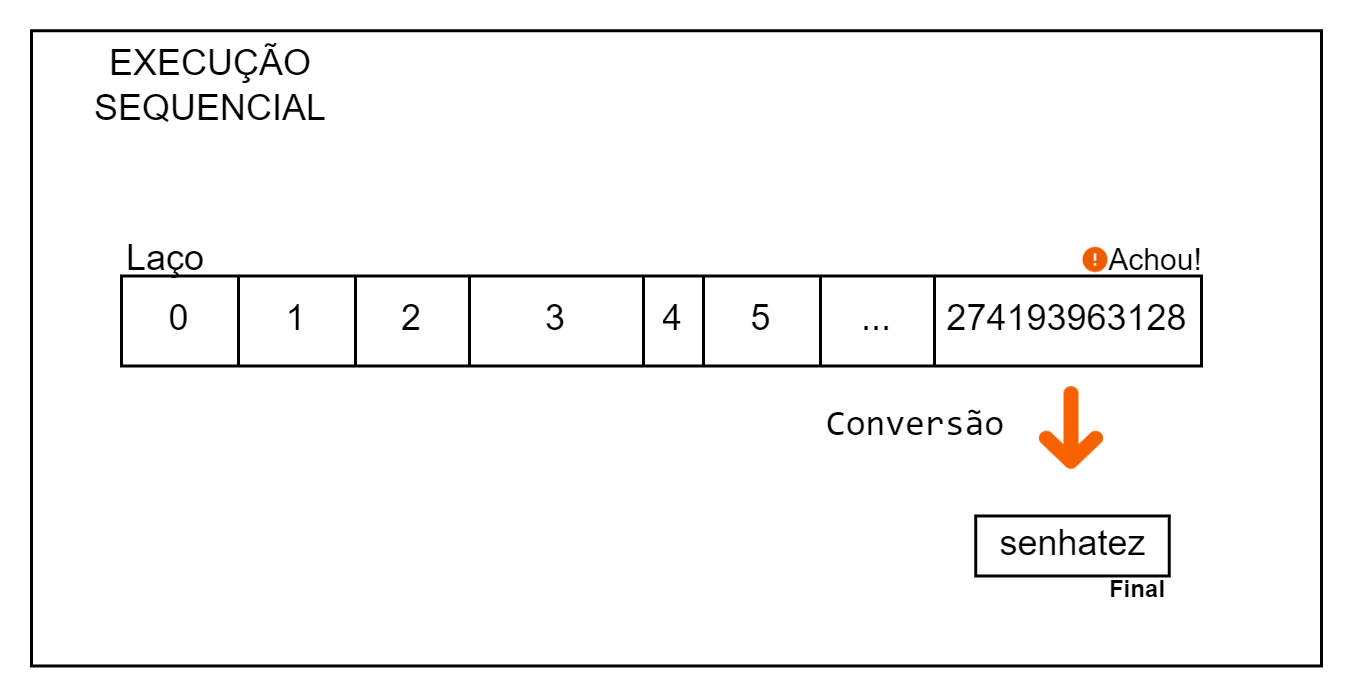

<font style='font-family:"Times New Roman"'>
<div style="text-align: justify">
<center></center>
<div align="center"><b>Figura 2 -</b> Processos de busca e retorno da base 10 para a senha original. </div>
</div>
</font>

<font style='font-family:"Times New Roman"'>
<div style="text-align: justify">

&emsp; Para compilar e executar o código sequencial são utilizados os seguintes comandos: 

</div>
</font>

In [ ]:
!gcc bruteforce.c -o bruteforce -std=c99 -pg

In [ ]:
!./bruteforce alows

Estamos tentando quebrar: alows

Este é o tempo do primeiro loop: 0.00 segundos

Este é o tempo do segundo loop: 0.00 segundos
Encontrou o password!
O número que estamos tentando encontrar (password na base decimal): 2300608590
Password encontrado: alows

Este é o tempo do terceiro loop: 8.00 segundos

8.00 seconds


---

## Profilling - Inicio do processo de paralelização.


<font style='font-family:"Times New Roman"'>
<div style="text-align: justify">

&emsp;Agora que conhecemos o algoritmo, se faz necessário estudar os pontos do código que exigem maior poder computacional para que possamos focar nossos esforços na paralelização desses trechos, desta maneira, conseguimos trabalhar de forma inteligente, onde o código realmente precisa ganhar desempenho. Para a realização dessa etapa, utilizamos uma ferramenta apresentada em sala, o GNU profiler (gprof) que faz parte do conjunto GNU Binary Utilities (binutils), ela tem como principal funcionalidade análisar e capturar os tempos durante a execução do código, gerando um relátorio final, assim podemos obter quanto tempo esta sendo gasto em cada bloco do seu programa e uma série de estatisticas relacionadas a chamada das funções no código. Além do _profilling_, também foram espalhados em lugares estratégicos do código, capturas de tempo com a função _time()_, para mensuramos o tempo de execução de cada trecho no código, em uma técnica de _tracing_. 

<br>&emsp; Para executar o processo de profilling é bem simples: basta inserir o argumento _-pg_ na compilação do nosso código sequencial, executá-lo normalmente para gerar o arquivo bruto do relatório e, logo depois, exibi-lo de forma legível através do comando: 
</div>
</font>

In [ ]:
!gprof -b bruteforce gmon.out

Flat profile:

Each sample counts as 0.01 seconds.
  %   cumulative   self              self     total           
 time   seconds   seconds    calls   s/call   s/call  name    
100.21      7.44     7.44        1     7.44     7.44  bruteForce
  0.00      7.44     0.00        6     0.00     0.00  my_pow
  0.00      7.44     0.00        1     0.00     0.00  printTime

			Call graph


granularity: each sample hit covers 2 byte(s) for 0.13% of 7.44 seconds

index % time    self  children    called     name
                7.44    0.00       1/1           main [2]
[1]    100.0    7.44    0.00       1         bruteForce [1]
                0.00    0.00       6/6           my_pow [3]
-----------------------------------------------
                                                 <spontaneous>
[2]    100.0    0.00    7.44                 main [2]
                7.44    0.00       1/1           bruteForce [1]
                0.00    0.00       1/1           printTime [4]
----------------------

<font style='font-family:"Times New Roman"'>
<div style="text-align: justify">

<br>&emsp;Após a geração do relatório de execução, podemos tirar conclusões importantes que vão definir nossos próximos passos. Como o esperado para um código dessa natureza, podemos observar que as funções _main_ e _my_pow_ não tem impacto significativo no tempo de execução do algoritmo, em contrapartida, a função _bruteforce_ é responsável por quase 100% do mesmo. Assim sendo, fica fácil de identificar os pontos de gargalo, partindo de um pressuposto que em um código, geralmente, o que mais consome tempo de execução são os laços e temos apenas três deles na função _bruteforce_.<br> 
&emsp;Os dois primeiros laços são baseados no tamanho da string, por isso a sua limitação de até 20 caracteres, principalmente considerando que a cada nova letra o tempo de execução aumenta exponencialmente, mas é o terceiro que exige mais poder computacional pois é nele que é realizada a busca em si pela palavra chave, onde o algoritmo conta de 0 até o número obtido na conversão da base decimal, um a um.<br>
&emsp;Para um viés de confirmação, posicionamos capturas de tempo antes e depois de cada laço, imprimindo no terminal o tempo de execução de cada um. Como esperado, os dois primeiros laços representam tempos insiginificantes, enquanto o laço de contagem consome a maior parte do tempo de execução do código.<br> 
&emsp; Com o estudo da execução do código realizado, estamos prontos para começar o processo de paralelização.

</div>
</font>

---
## Códigos Paralelizados



### Multicore - OPENMP

<font style='font-family:"Times New Roman"'>
<div style="text-align: justify">
&emsp;Aplicando a primeira técnica de paralelização do algoritmo será por meio da biblioteca OpenMP, que utiliza o paradigma de memória compartilhada com multithreads, dividindo o trabalho de execução entre múltiplas tarefas num mesmo processo. A ideia aqui é separar a busca pelo número inteiro que representa a palavra-chave entre mais de uma tarefa em simultâneo e de forma sincronizada. OpenMP é uma ferramenta poderosa de paralelização, que diminui erros de falha de segmentação de memória por falha humana através da automatização do processo de divisão de trabalho entre threads, assim, o programador apenas se preocupa com o alto nível da programação. 
</div>
</font>

```cpp
#include <stdio.h>
#include <stdlib.h>
#include <string.h>
#include <time.h>
#include <math.h>
#include <omp.h>

#define START_CHAR 48
#define END_CHAR 122
#define MAXIMUM_PASSWORD 20

long long my_pow(long long x, int y){
  long long res = 1;
  if (y==0)
    return res;
  else
    return x*my_pow(x,y-1);
}

void printTime(char *text, double time){
  FILE *f = fopen("omp_time.txt", "a");
  fprintf(f, "%s %d %1.2f\n", text, omp_get_num_threads(), time);
  fclose(f);
}

void bruteForce(char *pass) {
  time_t t1, t2;
  double dif;
  t1 = time(&t1);
  int size;
  size = strlen(pass);
  int pass_b26[size];
  long long int j;
  long long int pass_decimal = 0;
  int base = END_CHAR-START_CHAR+2;

  printf("Estamos tentando quebrar: %s\n", pass);

  for(int i = 0; i < size; i++){
    pass_b26[i] = (int)pass[i]-START_CHAR+1; 
  }
  for(int i = size - 1; i > -1; i--){
    pass_decimal += (long long int) pass_b26[i]*my_pow(base,i);
  }

  long long int max = my_pow(base,size);
  char s[size];
  int achou = 0;
  
  #pragma omp parallel for schedule(static) private(j) shared(achou) //Inicia a regiao paralela, com o schedule static, com "j" privado e "achou" compartilhado.
  for(j = 0; j < max; j++){
    if(achou == 1){//Se achou, as outras threads saem do loop
      exit(1); 
    }else{
      if(j == pass_decimal){
        printf("Encontrou o password!\n");
        int index = 0;
        printf("O número que estamos tentando encontrar (password na base decimal): %lli\n", j);
        while(j > 0){
          s[index++] = START_CHAR + j%base-1;
          j /= base;
        }
        s[index] = '\0';
        printf("Password encontrado: %s\n", s);
        time (&t2); 
        dif = difftime (t2,t1);
        printTime(pass, dif);
        printf("\n%1.2f seconds\n", dif);
        achou = 1; // Torna a flag como verdadeira
        exit(1); // encerra essa thread
      }
    }
    
  }
}

int main(int argc, char **argv) {
  omp_set_num_threads(atoi(argv[2])); //define o número de threads.
  bruteForce(argv[1]);
  return 0;
}
 

```

In [ ]:
#@title Escrever OMP
%%writefile bruteforce_omp.c
#include <stdio.h>
#include <stdlib.h>
#include <string.h>
#include <time.h>
#include <math.h>
#include <omp.h>

#define START_CHAR 48
#define END_CHAR 122
#define MAXIMUM_PASSWORD 20

long long my_pow(long long x, int y){
  long long res = 1;
  if (y==0)
    return res;
  else
    return x*my_pow(x,y-1);
}

void printTime(char *text, double time){
  FILE *f = fopen("omp_time.txt", "a");
  fprintf(f, "%s %d %1.2f\n", text, omp_get_num_threads(), time);
  fclose(f);
}

void bruteForce(char *pass) {
  time_t t1, t2;
  double dif;
  t1 = time(&t1);
  int size;
  size = strlen(pass);
  int pass_b26[size];
  long long int j;
  long long int pass_decimal = 0;
  int base = END_CHAR-START_CHAR+2;

  printf("Estamos tentando quebrar: %s\n", pass);

  for(int i = 0; i < size; i++){
    pass_b26[i] = (int)pass[i]-START_CHAR+1; 
  }
  for(int i = size - 1; i > -1; i--){
    pass_decimal += (long long int) pass_b26[i]*my_pow(base,i);
  }

  long long int max = my_pow(base,size);
  char s[size];
  int achou = 0;

  #pragma omp parallel for schedule(static) private(j) shared(achou) //Inicia a regiao paralela, com o schedule static, com "j" privado e "achou" compartilhado.
  for(j = 0; j < max; j++){
    if(achou == 1){//Se achou, as outras threads saem do loop
      exit(1); 
    }else{
      if(j == pass_decimal){
        printf("Encontrou o password!\n");
        int index = 0;
        printf("O número que estamos tentando encontrar (password na base decimal): %lli\n", j);
        while(j > 0){
          s[index++] = START_CHAR + j%base-1;
          j /= base;
        }
        s[index] = '\0';
        printf("Password encontrado: %s\n", s);
        time (&t2); 
        dif = difftime (t2,t1);
        printTime(pass, dif);
        printf("\n%1.2f seconds\n", dif);
        achou = 1; // Torna a flag como verdadeira
        exit(1); // encerra essa thread
      }
    }

  }
}

int main(int argc, char **argv) {
  omp_set_num_threads(atoi(argv[2])); //define o número de threads.
  bruteForce(argv[1]);
  return 0;
}

Writing bruteforce_omp.c


<font style='font-family:"Times New Roman"'>
<div style="text-align: justify">

&emsp;O código acima define o número de threads desejadas com a função _omp_set_num_threads()_, passadas como argumento pela linha de comando. Desta forma o código segue parecido com o sequencial, até chegar ao laço responsável por achar efetivamente a senha desejada. Neste laço, é iniciada uma região paralela com a diretiva _#pragma omp parallel for_, utilizada para a divisão das iterações naquele laço. Nesta região paralela, privamos a váriavel iterador "j", para que nenhuma thread interfira no processo de iteração da outra. Também definimos uma _flag_ definida pela váriavel inteira "achou" como compartilhada entre as threads, ela será a responsável por sinalizar quando a senha foi encontrada, encerrando o processo em todas as threads. Além disso, testamos várias maneiras de separar as iterações entre as threads, e a forma na qual obtivemos o melhor desempenho foi as dividindo de maneira igualitária, através do schedule _static_.<br>
&emsp;Desta forma, ao entrar na região paralela, todas as threads entram em ação, realizando as interações em um mesmo laço e procurando pela senha ao mesmo tempo que verificam o estado da váriavel "achou", como representado pela figura 3. Assim que uma das threads encontra a chave, ela torna a _flag_ "achou" igual a 1, como a variável "achou" é compartilhada e todas as threads podem acessar seu valor, cada thread encerra o processo na verificação no início do laço de contagem.  


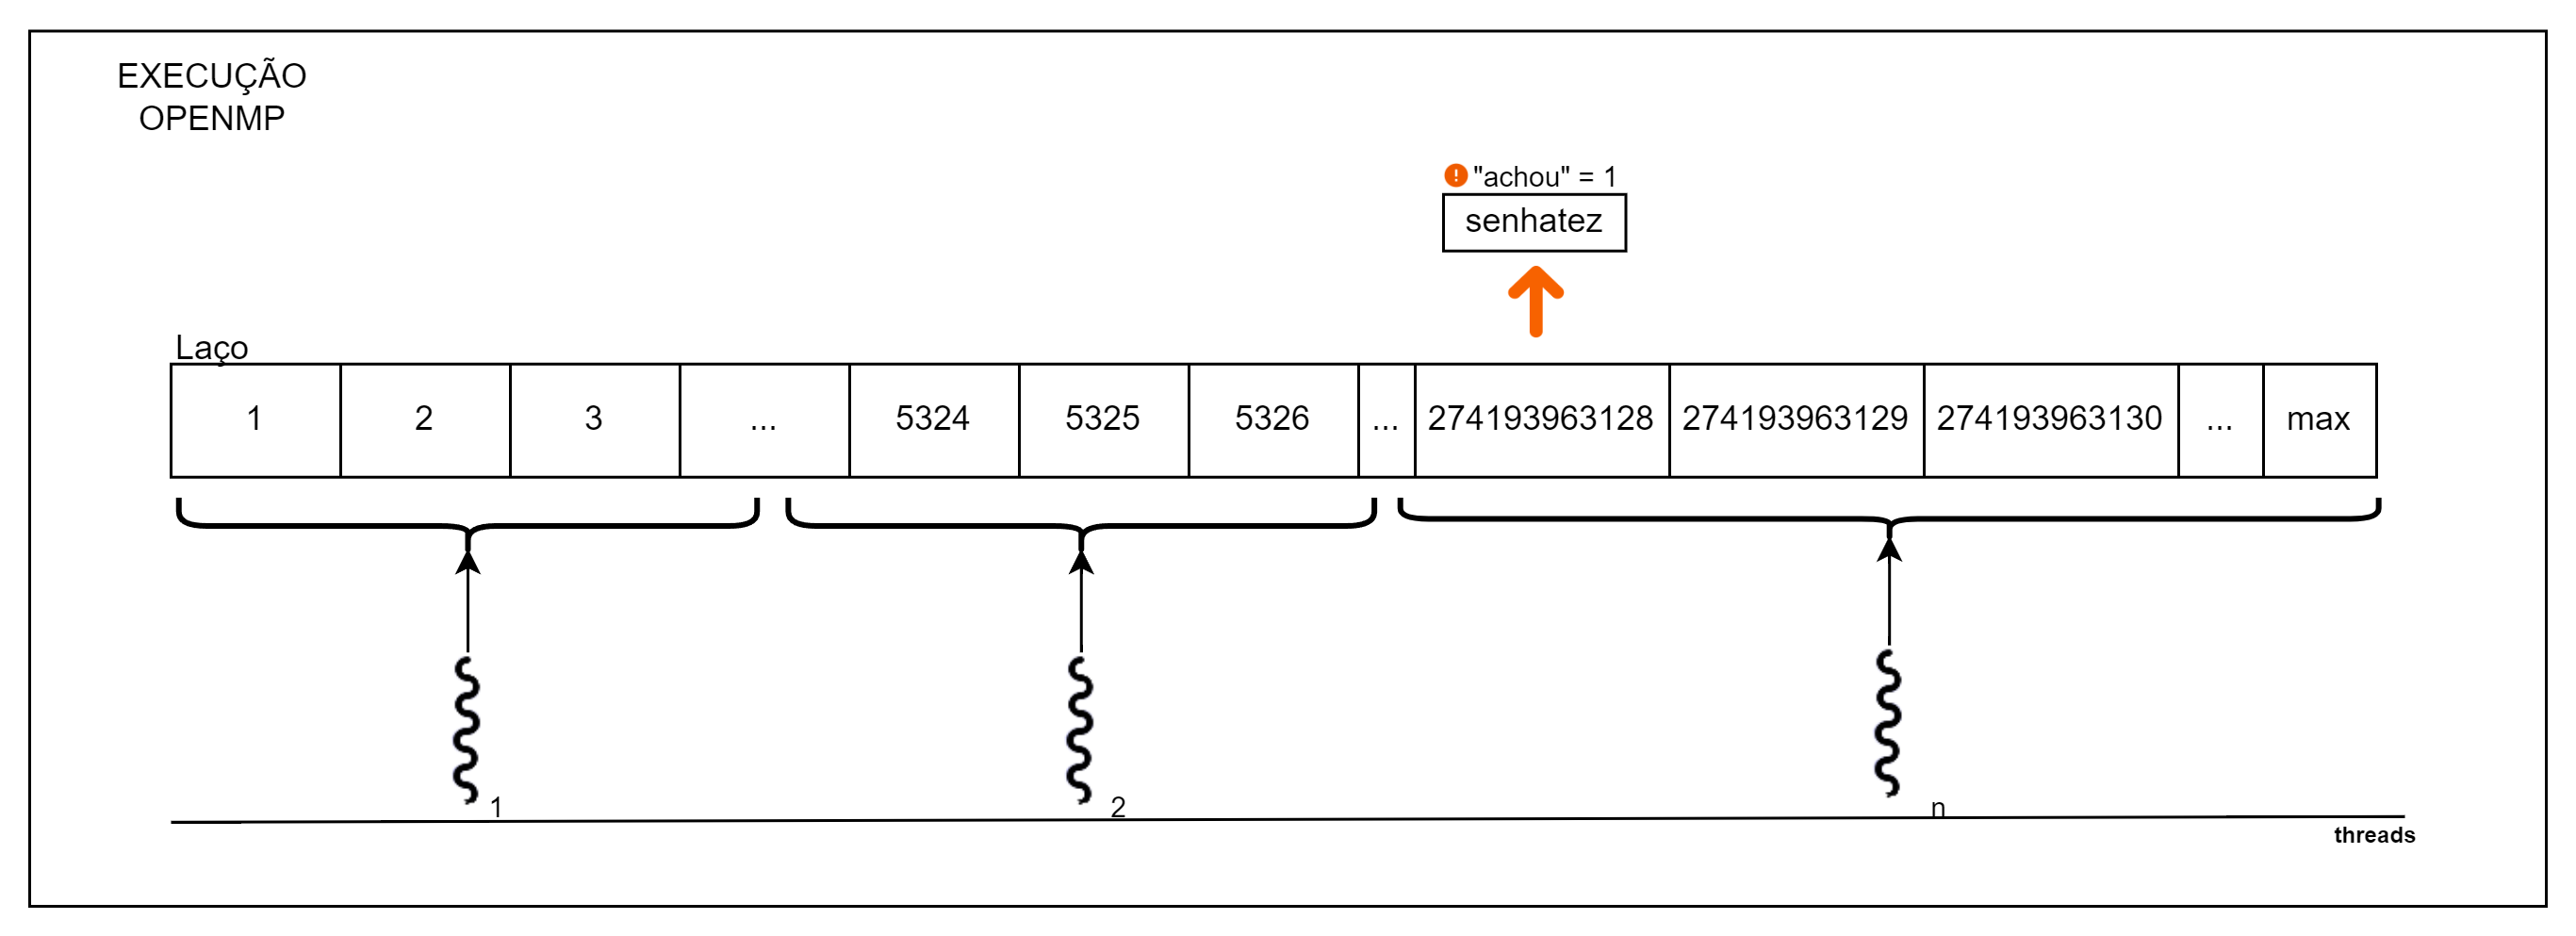

<div align="center"><b>Figura 3 -</b> Funcionamento da mecânica de procura entre as threads.</div>
&emsp; Para compilar e executar o código, utilizamos os seguintes comandos:
</div>
</font>

In [ ]:
!gcc bruteforce_omp.c -o bruteforce_omp -fopenmp -O3 -std=c99

In [ ]:
!./bruteforce_omp alows 32

Estamos tentando quebrar: alows
Encontrou o password!
O número que estamos tentando encontrar (password na base decimal): 2300608590
Password encontrado: alows

0.00 seconds


### Multiprocessado - MPI

<font style='font-family:"Times New Roman"'>
    <div style="text-align: justify">
    &emsp;A segunda tentativa de paralelismo foi ultilizando a biblioteca Message Passing Interface (MPI), que é uma interface para comunicação de dados através de envio e recebimento de mensagens. MPI é muito utilizado na computação paralela, permitindo a implementação do paradigma de memória distribuída onde vários processos diferentes trabalham em conjunto de forma síncrona e paralela dentro de um mesmo código.<br>
    &emsp;Desta forma, nenhum dos processos consegue acessar a memória do outro, se comunicando exclusivamente por envio e recebimento de pacotes, podendo esses serem síncronos (bloqueantes) ou assíncronos (não bloqueantes). Envios síncronos garantem maior segurança, tendo em vista que o processo permanece bloqueado até que o pacote seja recebecido, entretanto durante esse periodo os outros processos permanecem ociosos', o que pode levar a uma perda de desempenho. Já os envios não bloqueantes não interferem no funcionamento do processo, o que pode levar a um melhor desempenho caso o recebimento de todos os pacotes não seja um ponto crítico, ou o mesmo seja tratado de forma diferente.<br>
    &emsp;Uma proposta parecida com a feita anteriormente, no OpenMP, foi a realizad: dividir a área de busca dentro do laço de contagem entre os processos, para que todos procurem a senha ao mesmo tempo, diminuindo o tempo de execução do código. 
</div>
</font>

```cpp

#include <stdio.h>
#include <stdlib.h>
#include <string.h>
#include <time.h>
#include <mpi.h>

#define START_CHAR 48
#define END_CHAR 122
#define MAXIMUM_PASSWORD 20

void bruteForce(char *pass, int np, int id);
long long my_pow(long long x, int y);

void bruteForce(char *pass, int np, int num_processo) {
  time_t t1, t2;
  double dif;
  int size;
  size = strlen(pass);
  t1 = time (&t1);
  int pass_b26[size];
  long long int j;
  long long int pass_decimal = 0;
  int base = END_CHAR-START_CHAR+2;
  
  for(int i = 0; i < size; i++){
    pass_b26[i] = (int)pass[i]-START_CHAR+1;
  }
  for(int i = size - 1; i > -1; i--){
    pass_decimal += (long long int) pass_b26[i]*my_pow(base,i);
  }

  long long int max = my_pow(base,size);
  char s[size];
  for(j = num_processo*max/np; j != (num_processo+1)*max/np; j++){ // divide o trabalho entre os processos, de acordo com o seu identificador, e o numero de processos totais, e o maximo de tentativas.
    if(j == pass_decimal){ //achou o processo
      int index = 0;
      while(j > 0){
        s[index++] = START_CHAR + j%base-1;
        j /= base;
      }
      s[index] = '\0';
      printf("Password encontrado pelo processo %d: %s\n", num_processo, s);
      t2 = time (&t2);
      dif = difftime(t2,t1);
      printf("Tempo de execução: %1.2f\n", dif);
      MPI_Abort( MPI_COMM_WORLD , 1); // encerra todos os processos 
    }
  }
}

long long my_pow(long long x, int y)
{
  long long res = 1;
  if (y==0)
    return res;
  else
    return x*my_pow(x,y-1);
}

int main(int argc, char **argv) {
  int np, num_processo;
  MPI_Init(&argc, &argv);
  MPI_Comm_size(MPI_COMM_WORLD, &np);
  MPI_Comm_rank(MPI_COMM_WORLD, &num_processo);
  bruteForce(argv[1], np, num_processo);
}


```

In [ ]:
#@title Escrever MPI
%%writefile bruteforce_mpi.c
#include <stdio.h>
#include <stdlib.h>
#include <string.h>
#include <time.h>
#include <mpi.h>

#define START_CHAR 48
#define END_CHAR 122
#define MAXIMUM_PASSWORD 20

void bruteForce(char *pass, int np, int id);
long long my_pow(long long x, int y);

void printTime(char *text, double time, int np){
  FILE *f = fopen("mpi_time.txt", "a");
  fprintf(f, "%s %d %1.2f\n", text, np, time);
  fclose(f);
}

void bruteForce(char *pass, int np, int num_processo) {
  time_t t1, t2;
  double dif;
  int size;
  size = strlen(pass);
  t1 = time (&t1);
  int pass_b26[size];
  long long int j;
  long long int pass_decimal = 0;
  int base = END_CHAR-START_CHAR+2;

  for(int i = 0; i < size; i++){
    pass_b26[i] = (int)pass[i]-START_CHAR+1;
  }
  for(int i = size - 1; i > -1; i--){
    pass_decimal += (long long int) pass_b26[i]*my_pow(base,i);
  }

  long long int max = my_pow(base,size);
  char s[size];
  for(j = num_processo*max/np; j < (num_processo+1)*max/np; j++){ // divide o trabalho entre os processos, de acordo com o seu identificador, e o numero de processos totais, e o maximo de tentativas.
    if(j == pass_decimal){ //achou o processo
      int index = 0;
      while(j > 0){
        s[index++] = START_CHAR + j%base-1;
        j /= base;
      }
      s[index] = '\0';
      printf("Password encontrado pelo processo %d: %s\n", num_processo, s);
      t2 = time (&t2);
      dif = difftime(t2,t1);
      printTime(pass, dif, np);
      printf("Tempo de execução: %1.2f\n", dif);
      MPI_Abort( MPI_COMM_WORLD , 1); // encerra todos os processos 
    }
  }
}

long long my_pow(long long x, int y)
{
  long long res = 1;
  if (y==0)
    return res;
  else
    return x*my_pow(x,y-1);
}

int main(int argc, char **argv) {
  int np, num_processo;
  MPI_Init(&argc, &argv);
  MPI_Comm_size(MPI_COMM_WORLD, &np);
  MPI_Comm_rank(MPI_COMM_WORLD, &num_processo);
  bruteForce(argv[1], np, num_processo);
}


Writing bruteforce_mpi.c


<font style='font-family:"Times New Roman"'>
<div style="text-align: justify">

<br>&emsp;O código acima trabalha com vários processos, mas conseguimos achar uma maneira dos processos trabalharem em conjunto sem envio ou recebimento de mensagens explícitas, conforme referênciado na figura 4 semelhante ao OpenMP. Baseado no número de identificação de cada processo, obtido através da função _MPI_Comm_rank()_ e do número total de processos obtido através da função _MPI_Comm_size_, o intervalo de procura é definido dentro do laço de contagem usando uma conta matemática simples, assim, cada processo procura a combinação referente à palavra-chave, em um intervalo único e específico, paralelamente. Desta forma, quando algum dos processos acha a senha, ele imprime o resultado no console, e logo em seguida aborta todos os processos com a função <i>MPI_Abort()</i>.<br>




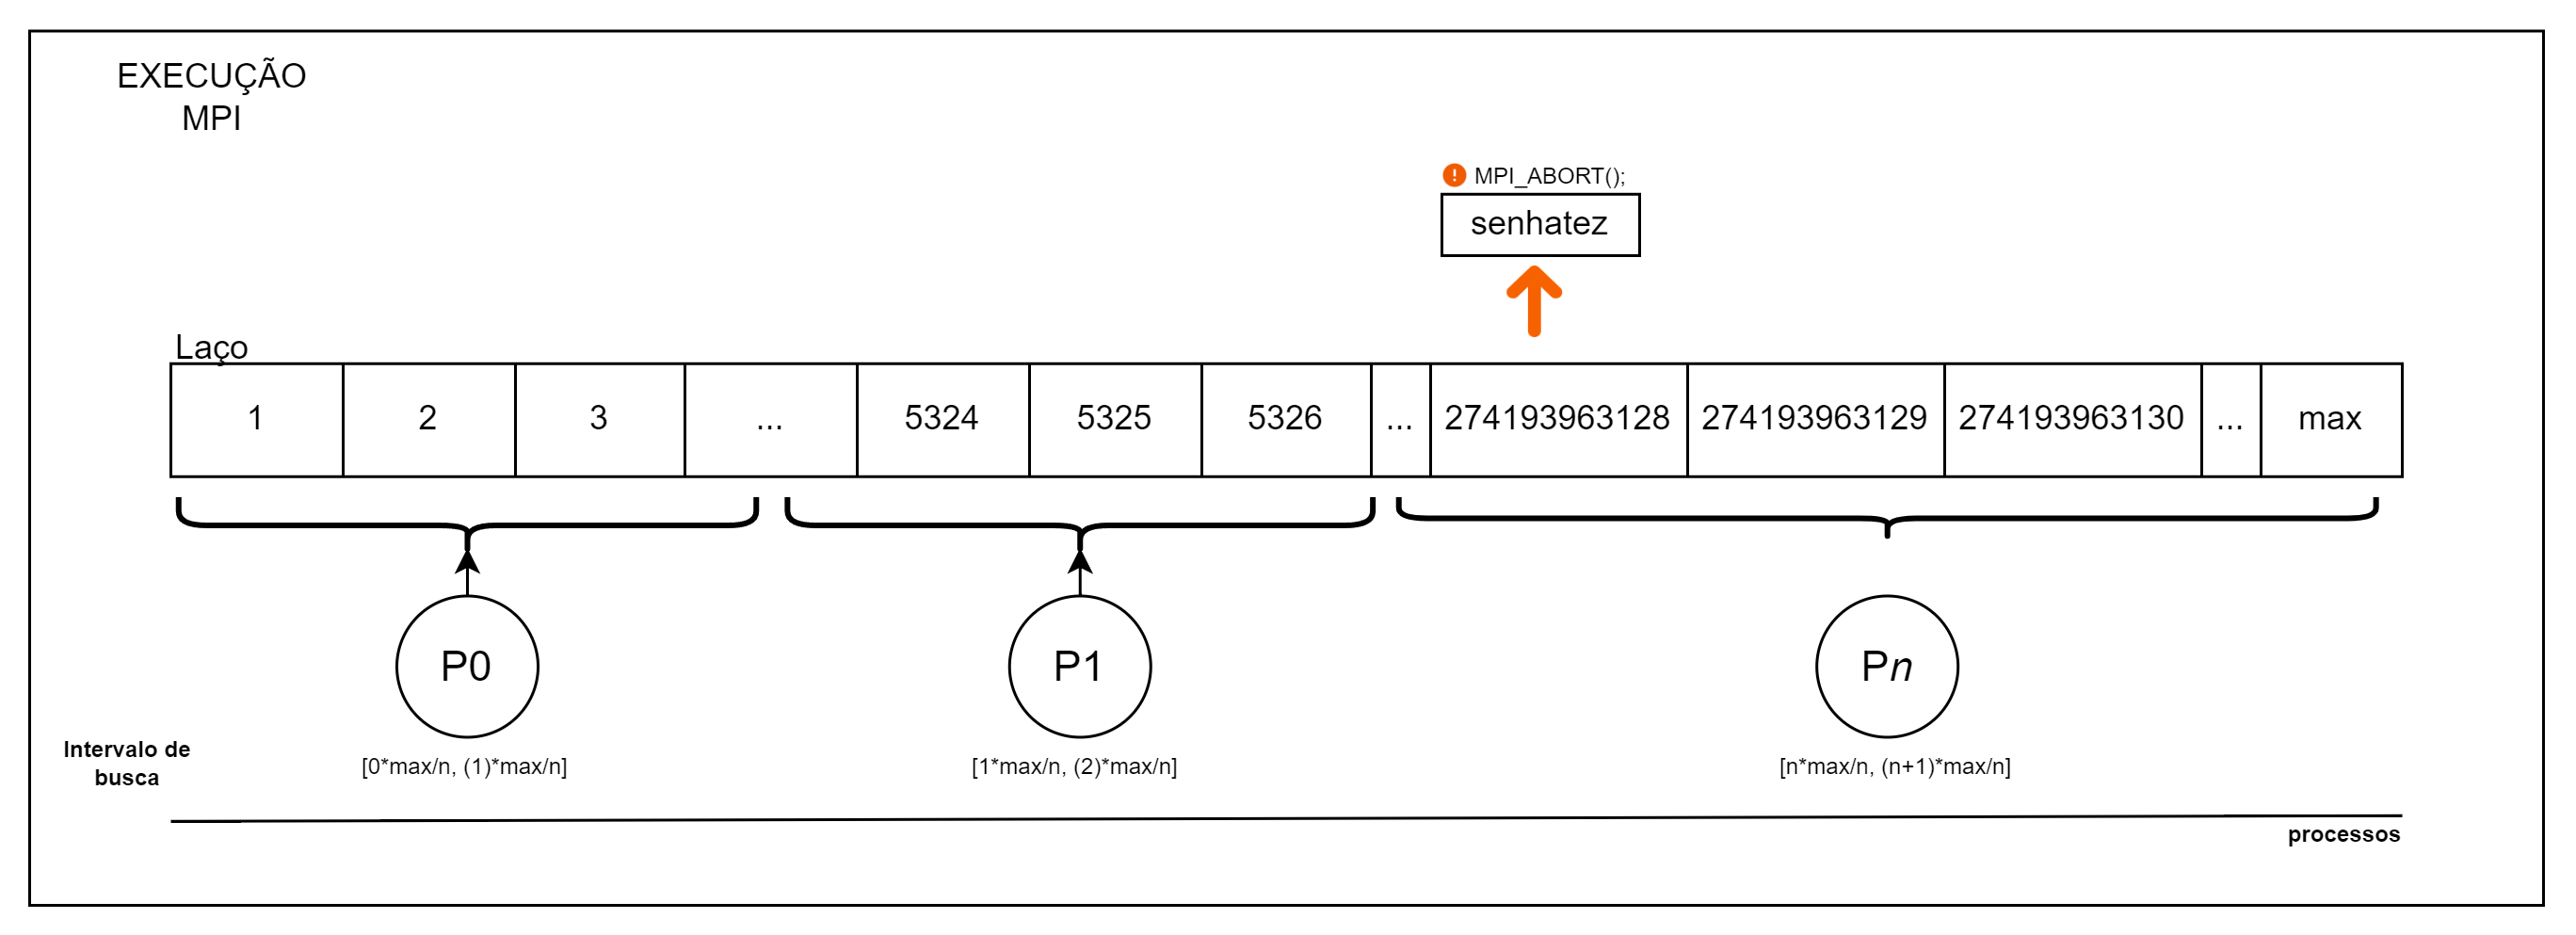

<div align="center"><b>Figura 4 -</b> Representação da execução no código MPI.</div>

&emsp;Para compilar e executar o código acima utilizamos os seguintes comandos:

</div>
</font>

In [ ]:
!mpicc bruteforce_mpi.c -o bruteforce_mpi -std=c99 -O3

In [ ]:
!mpirun -np 4 --allow-run-as-root ./bruteforce_mpi alows

Password encontrado pelo processo 3: alows
Tempo de execução: 0.00
--------------------------------------------------------------------------
MPI_ABORT was invoked on rank 3 in communicator MPI_COMM_WORLD
with errorcode 1.

NOTE: invoking MPI_ABORT causes Open MPI to kill all MPI processes.
You may or may not see output from other processes, depending on
exactly when Open MPI kills them.
--------------------------------------------------------------------------


### Hibrido - MPI e OpenMP


<font style='font-family:"Times New Roman"'>
<div style="text-align: justify">
&emsp;A terceira abordagem é uma tentativa de mesclar as duas técnicas previamente utilizadas,em um sistema híbrido, utilizando OpenMP dentro de MPI. Como já explicamos anteriormente, a técnica com OpenMP consiste na divisão do trabalho entre as threads enquanto MPI faz essa divisão entre os processos, de forma análoga em um modelo híbrido, dividimos as tarefas entre processos, que por sua vez, dividem as tarefas entre processos, com cada processo abrindo múltiplas threads e dividindo igualmente entre elas no intervalo ao qual ele é responsável dentro do algoritmo.<br> 
</div>
</font>

```cpp
#include <stdio.h>
#include <stdlib.h>
#include <string.h>
#include <time.h>
#include <mpi.h>
#include <omp.h>


#define START_CHAR 48
#define END_CHAR 122
#define MAXIMUM_PASSWORD 20

void bruteForce(char *pass, int np, int id);
long long my_pow(long long x, int y);

void printTime(char *text, double time, int np){
  FILE *f = fopen("hybrid_time.txt", "a");
  fprintf(f, "%s %d %d %1.2f\n", text, np, omp_get_num_threads(), time);
  fclose(f);
}

void bruteForce(char *pass, int np, int num_processo) {
  time_t t1, t2;
  double dif;
  int size;
  int achou = 0;
  size = strlen(pass);
  t1 = time (&t1);
  int pass_b26[size];
  //long long int j;
  long long int pass_decimal = 0;
  int base = END_CHAR-START_CHAR+2;

  for(int i = 0; i < size; i++){
    pass_b26[i] = (int)pass[i]-START_CHAR+1;
  }
  for(int i = size - 1; i > -1; i--){
    pass_decimal += (long long int) pass_b26[i]*my_pow(base,i);
  }

  long long int max = my_pow(base,size);
  char s[size];

  #pragma omp parallel for schedule(static) private(j) shared(achou)// inicio da regiao paralela
  for(long long int j = num_processo*max/np; j != (num_processo+1)*max/np; j++){ // divide o trabalho entre os processo
    if(j == pass_decimal){
      int index = 0;
      while(j > 0){
        s[index++] = START_CHAR + j%base-1;
        j /= base;
      }
      s[index] = '\0';
      printf("Password encontrado pelo processo %d: %s\n", num_processo, s);
      t2 = time (&t2);
      dif = difftime(t2,t1);
      printTime(pass, dif, np);
      printf("Tempo de execução: %1.2f\n", dif);
      achou = 1;
      MPI_Abort( MPI_COMM_WORLD , achou);
    }
  }
}

long long my_pow(long long x, int y)
{
  long long res = 1;
  if (y==0)
    return res;
  else
    return x*my_pow(x,y-1);
}

int main(int argc, char **argv) {
  int np, num_processo;
  MPI_Init(&argc, &argv);
  MPI_Comm_size(MPI_COMM_WORLD, &np);
  MPI_Comm_rank(MPI_COMM_WORLD, &num_processo);
  omp_set_num_threads(atoi(argv[2]));
  bruteForce(argv[1], np, num_processo);
}
```

In [18]:
#@title Escrever Hibrido
%%writefile bruteforce_hibrido.c
#include <stdio.h>
#include <stdlib.h>
#include <string.h>
#include <time.h>
#include <mpi.h>
#include <omp.h>


#define START_CHAR 48
#define END_CHAR 122
#define MAXIMUM_PASSWORD 20

void bruteForce(char *pass, int np, int id);
long long my_pow(long long x, int y);

void printTime(char *text, double time, int np){
  FILE *f = fopen("hybrid_time.txt", "a");
  fprintf(f, "%s %d %d %1.2f\n", text, np, omp_get_num_threads(), time);
  fclose(f);
}

void bruteForce(char *pass, int np, int num_processo) {
  time_t t1, t2;
  double dif;
  int size;
  int achou = 0;
  size = strlen(pass);
  t1 = time (&t1);
  int pass_b26[size];
  //long long int j;
  long long int pass_decimal = 0;
  int base = END_CHAR-START_CHAR+2;

  for(int i = 0; i < size; i++){
    pass_b26[i] = (int)pass[i]-START_CHAR+1;
  }
  for(int i = size - 1; i > -1; i--){
    pass_decimal += (long long int) pass_b26[i]*my_pow(base,i);
  }

  long long int max = my_pow(base,size);
  char s[size];

  #pragma omp parallel for schedule(static) shared(achou)// inicio da regiao paralela
  for(long long int j = num_processo*max/np; j < (num_processo+1)*max/np; j++){ // divide o trabalho entre os processo
    if(j == pass_decimal){
      int index = 0;
      while(j > 0){
        s[index++] = START_CHAR + j%base-1;
        j /= base;
      }
      s[index] = '\0';
      printf("Password encontrado pelo processo %d: %s\n", num_processo, s);
      t2 = time (&t2);
      dif = difftime(t2,t1);
      printTime(pass, dif, np);
      printf("Tempo de execução: %1.2f\n", dif);
      achou = 1;
      MPI_Abort( MPI_COMM_WORLD , achou);
    }
  }
}

long long my_pow(long long x, int y)
{
  long long res = 1;
  if (y==0)
    return res;
  else
    return x*my_pow(x,y-1);
}

int main(int argc, char **argv) {
  int np, num_processo;
  MPI_Init(&argc, &argv);
  MPI_Comm_size(MPI_COMM_WORLD, &np);
  MPI_Comm_rank(MPI_COMM_WORLD, &num_processo);
  omp_set_num_threads(atoi(argv[2]));
  bruteForce(argv[1], np, num_processo);
}

Overwriting bruteforce_hibrido.c


<font style='font-family:"Times New Roman"'>
<div style="text-align: justify">
&emsp;O código acima é bem semelhante aos apresentados anteriormente, visto que é uma fusão entre os paradigmas de programação. Novamente iniciamos os processos e dividimos os intervalos do laço de contagem entre os processos, baseado no tamanho máximo da senha tranformada em base 10, o identificador de cada processo e o número total de processos como no código em MPI. Feito isso, paralelizamos o mesmo laço, utilizando da  diretiva _#pragma omp parallel for_ para iniciar a região paralela, colocando as váras threads em execução como feito no código em OpenMP. Desta forma, em cada processo várias threads são iniciadas para buscar a combinação dentro do laço, como representado pela figura 5.<br><br>




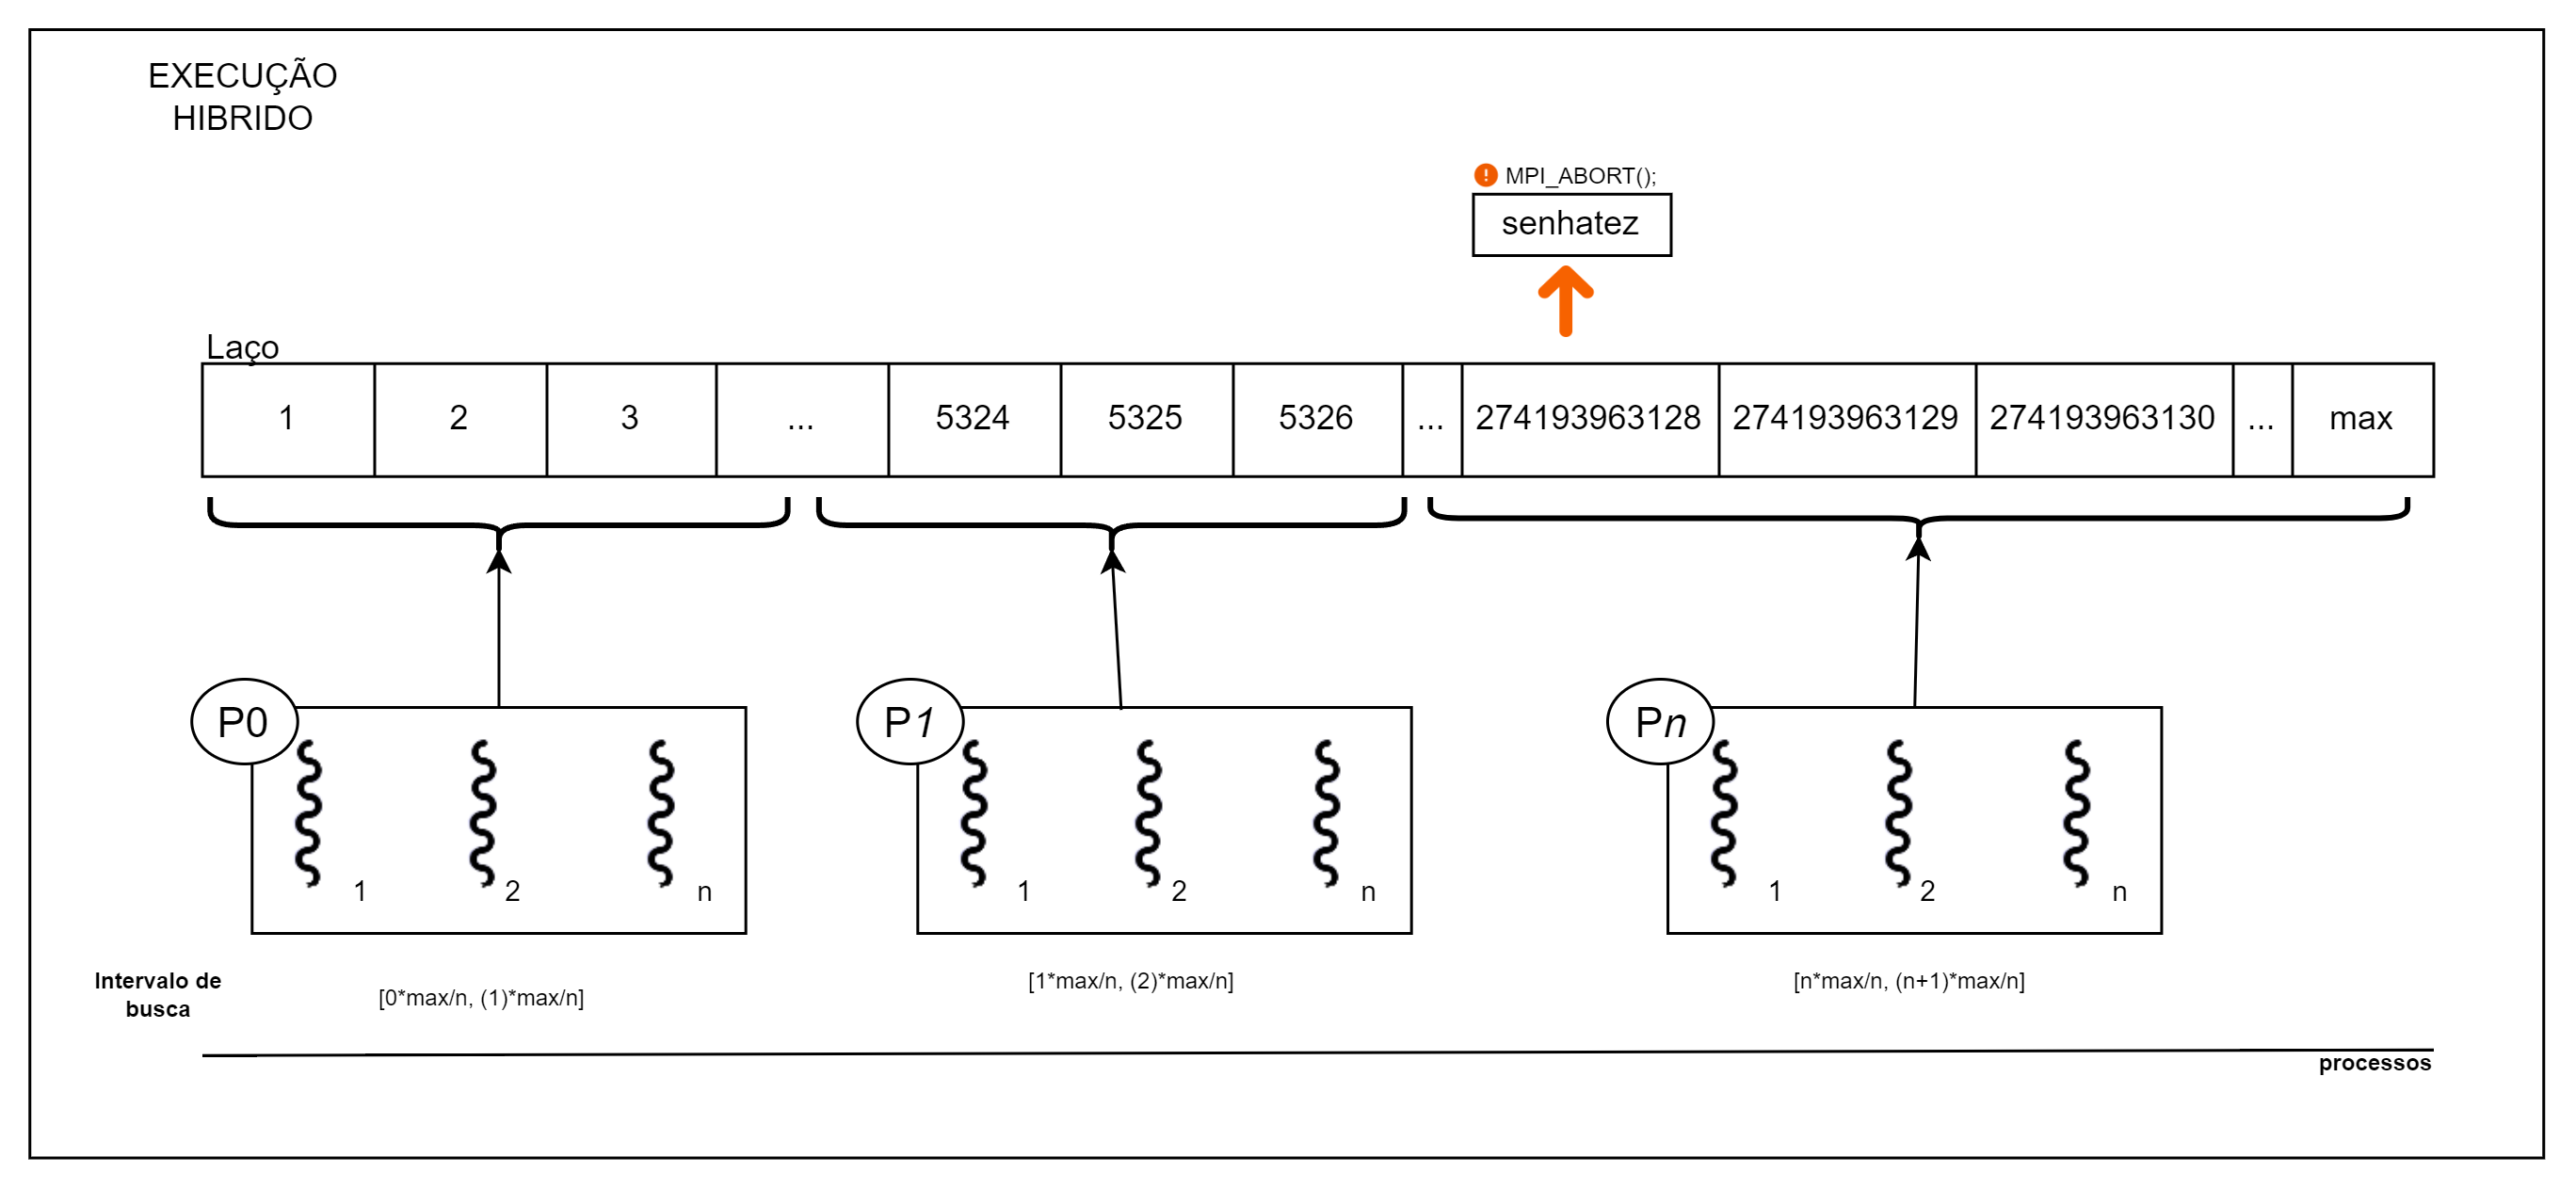

<div align="center"><b>Figura 5 -</b> Representação da execução no código Híbrido.</div>

&emsp;Para compilar e executar o código acima utilizamos os seguintes comandos:
</div>
</font>

In [19]:
!mpicc bruteforce_hibrido.c -o bruteforce_hibrido -fopenmp -std=c99 -O3 

In [20]:
!mpirun -np 8 --allow-run-as-root ./bruteforce_hibrido alows 8

Password encontrado pelo processo 7: alows
--------------------------------------------------------------------------
MPI_ABORT was invoked on rank 7 in communicator MPI_COMM_WORLD
with errorcode 1.

NOTE: invoking MPI_ABORT causes Open MPI to kill all MPI processes.
You may or may not see output from other processes, depending on
exactly when Open MPI kills them.
--------------------------------------------------------------------------
Tempo de execução: 0.00


### Processamento em GPU - CUDA


```cpp
#include <stdio.h>
#include <stdlib.h>
#include <string.h> 
#include <time.h>
#include <math.h>
#include <cuda.h> // importa a biblioteca CUDA
#include <string>
#include <cstring>
#include <assert.h>
using namespace std; //define o namespace padrão

//97 to 122 use only lowercase letters
//65 to 90 use only capital letters
//48 to 57 use only numbers
#define START_CHAR 48
#define END_CHAR 122
#define MAXIMUM_PASSWORD 20

__device__ long long my_pow(long long x, int y){//funcao para calcular potencia, marcada com __device__ para ser executada no device 

  long long res = 1;

  if (y == 0)
    return res;
  else
    return x * my_pow(x, y-1);

}
__device__ int my_strlen(char *s) {
    int sum = 0;
    while (*s++) sum++;
    return sum;
 }

__global__ void bruteForce(char *pass) { //define a função que poderá ser chamada globalmente, como kernel 
  long long j = blockIdx.x*blockDim.x+threadIdx.x;
  int tam = my_strlen(pass);
  int pass_b26[MAXIMUM_PASSWORD];

  long long int pass_decimal = 0;
  int base = END_CHAR-START_CHAR+2;

  for(int i = 0; i < tam; i++){
    pass_b26[i] = (int)pass[i]-START_CHAR+1;
  }
  for(int i = tam - 1; i > -1; i--){
    pass_decimal += (long long int) pass_b26[i]*my_pow(base,i);
  }

  long long int max = my_pow(base,tam);
  char s[MAXIMUM_PASSWORD];

  while(j < max){
      if(j == pass_decimal){
        printf("Encontrou o password!\n");
        int index = 0;
        printf("O número que estamos tentando encontrar (password na base decimal): %lli\n", j);
        while(j > 0){
          s[index++] = START_CHAR + j%base-1;
          j /= base;
        }
        s[index] = '\0';
        printf("Password encontrado: %s\n", s);
        assert(0);
        break;
      }
      j += blockDim.x*gridDim.x; //move o stride loop
  }
    
}

void printTime(char *text, double time){
  FILE *f = fopen("cuda_time.txt", "a");
  fprintf(f, "%s %1.2f\n", text, time);
  fclose(f);
}

int main(int argc, char **argv) {
  //int id;
  //int numsms;
  //cudaGetDevice(&id); //pega o identificador do device
  //cudaDeviceGetAttribute(&numsms, cudaDevAttrMultiProcessorCount, id); //pega o número de multiprocessadores do device e o número de SMS
  char *password_gpu; //ponteiro para a variável que será alocada no device
  
  cudaMallocManaged(&password_gpu, MAXIMUM_PASSWORD); //linka ás memórias do device e do host a variável password_gpu
  strcpy(password_gpu, argv[1]); // copia a variavel para duas memorias

  time_t t1, t2;
  double dif;
  int blocos = 80 * atoi(argv[2]); //define o número de blocos
  time(&t1);
  bruteForce<<< blocos, 1024 >>>(password_gpu); //chama o kernel, passando o numero de blocos e threads por bloco
  cudaDeviceSynchronize(); // Espera todas as threads terminarem dentro da GPU
  time(&t2);
  dif = difftime (t2,t1);
  printf("\n%1.2f seconds\n", dif);
  printTime(argv[1], dif);
  cudaFree(password_gpu);
  return 0;

}

```

In [23]:
#@title Escrever CUDA
%%writefile bruteforce_cuda.cu
# include <stdio.h>
# include <stdlib.h>
# include <string.h> 
# include <time.h>
# include <math.h>
# include <cuda.h> // importa a biblioteca CUDA
# include <string>
# include <cstring>
# include <assert.h>
using namespace std; //define o namespace padrão

//97 to 122 use only lowercase letters
//65 to 90 use only capital letters
//48 to 57 use only numbers
# define START_CHAR 48
# define END_CHAR 122
# define MAXIMUM_PASSWORD 20

__device__ long long my_pow(long long x, int y){//funcao para calcular potencia, marcada com __device__ para ser executada no device 

  long long res = 1;

  if (y == 0)
    return res;
  else
    return x * my_pow(x, y-1);

}
__device__ int my_strlen(char *s) {
    int sum = 0;
    while (*s++) sum++;
    return sum;
 }

__global__ void bruteForce(char *pass) { //define a função que poderá ser chamada globalmente, como kernel 
  long long j = blockIdx.x*blockDim.x+threadIdx.x;
  int tam = my_strlen(pass);
  int pass_b26[MAXIMUM_PASSWORD];

  long long int pass_decimal = 0;
  int base = END_CHAR-START_CHAR+2;

  for(int i = 0; i < tam; i++){
    pass_b26[i] = (int)pass[i]-START_CHAR+1;
  }
  for(int i = tam - 1; i > -1; i--){
    pass_decimal += (long long int) pass_b26[i]*my_pow(base,i);
  }

  long long int max = my_pow(base,tam);
  char s[MAXIMUM_PASSWORD];

  while(j < max){
      if(j == pass_decimal){
        printf("Encontrou o password!\n");
        int index = 0;
        printf("O número que estamos tentando encontrar (password na base decimal): %lli\n", j);
        while(j > 0){
          s[index++] = START_CHAR + j%base-1;
          j /= base;
        }
        s[index] = '\0';
        printf("Password encontrado: %s\n", s);
        assert(0);
        break;
      }
      j += blockDim.x*gridDim.x; //move o stride loop
  }

}

void printTime(char *text, double time, int numForBlocks){
  FILE *f = fopen("cuda_time.txt", "a");
  fprintf(f, "%s %d %1.2f\n", text, numForBlocks, time);
  fclose(f);
}

int main(int argc, char **argv) {
  int id;
  int numsms;
  cudaGetDevice(&id); //pega o identificador do device
  cudaDeviceGetAttribute(&numsms, cudaDevAttrMultiProcessorCount, id); //pega o número de multiprocessadores do device e o número de SMS
  char *password_gpu; //ponteiro para a variável que será alocada no device

  cudaMallocManaged(&password_gpu, MAXIMUM_PASSWORD); //linka ás memórias do device e do host a variável password_gpu
  strcpy(password_gpu, argv[1]); // copia a variavel para duas memorias

  time_t t1, t2;
  double dif;
  int blocos = numsms * atoi(argv[2]); //define o número de blocos
  time(&t1);
  bruteForce<<< blocos, 1024 >>>(password_gpu); //chama o kernel, passando o numero de blocos e threads por bloco
  cudaDeviceSynchronize(); // Espera todas as threads terminarem dentro da GPU
  time(&t2);
  dif = difftime (t2,t1);
  printf("\n%1.2f seconds\n", dif);
  printTime(argv[1], dif, blocos);
  cudaFree(password_gpu);
  return 0;

}

Overwriting bruteforce_cuda.cu



<font style='font-family:"Times New Roman"'>
<div style="text-align: justify">

<br>&emsp;O código acima se inicia capturando o nosso _device_, e logo depois, captura as características dele, para obtermos os número de SM's disponíveis. Assim, podemos calcular quantos blocos que serão criados dentro do _kernel_. Cada bloco por padrão só pode suportar no máximo 1024 _threads_, por isso ao chamar o _kernel_, definimos o número de 1024 _threads_ por bloco. O kernel da função _bruteforce()_ conta agora com a _flag_ "global", permitindo que ela seja chamada globalmente, tanto pelo _host_, como pelo _device_. Para ganharmos desempenho, comentamos essas linhas de códigos, uma vez que não eram mais úteis. <br>
&emsp;O modelo de memória, utilizado no código é o link de memória onde linkamos a variável _password__gpu_ ao mesmo endereço de memória, desta forma, alterar o conteúdo dela no _host_ ou no _device_ não faz diferença, já que as mundaças vão para ambas as memórias alocadas, para isso, utilizamos a função _cudaMallocManaged()_ .<br>
&emsp;Desta forma, ao chamar o kernel,a função roda inicialmente igual ao sequencial, com a diferença de que as funções padrões no c, como _strlen()_, são inacessíveis no device, apenas na CPU, por isso, utilizamos a função <i>my_strlen()</i> no lugar. Além disso, o modo de execução da GPU conta com modelo do _stride loop_, que funciona como representado na figura 8. No _stride loop_, as iterações do laço de contagem são divididas entre os blocos, de acordo com os números de threads, assim, quando uma thread termina uma interação, ela passa o trabalho para sua thread vizinha pertencente ao próximo bloco. Como o problema de bruteforce é de natureza unidimensional, optamos por utilizar apenas 1 Grid, o loop acaba quando algumas das threads acha a senha, quebrando o _kernel_ com a função assert.<br> 

<center><img src="https://drive.google.com/uc?id=1EB2iS_Os1oSgR2pXIJkoDyHheHdlNsb-" width="1100" height=auto></center>
<div align="center"><b>Figura 8 -</b> Representação da execução do código em CUDA, com stride loop.</div>

&emsp;Por fim, depois de executarmos o kernel, utilizamos a função _cudaDeviceSynchronize()_ para sincronnizar as threads e logo após _cudaFree()_ para desalocar a memória que alocamos na GPU.<br>
&emsp;Para compilar e executar o código acima, utilize os seguintes comandos:
</div>
</font>


In [24]:
!nvcc bruteforce_cuda.cu -o bruteforce_cuda

In [25]:
!./bruteforce_cuda alows 64

Encontrou o password!
O número que estamos tentando encontrar (password na base decimal): 2300608590
Password encontrado: alows
bruteforce_cuda.cu:64: void bruteForce(char *): block: [1568,0,0], thread: [78,0,0] Assertion `0` failed.

0.00 seconds


## Análise Experimental


<font style='font-family:"Times New Roman"'>
<div style="text-align: justify">

<br>&emsp; Para realizar uma análise válida não basta apenas aplicar as técnicas de paralelização nos códigos em si. Existem outras váriavéis que podem interferir no desempenho do nosso código, por isso, a equipe codificou scripts em _shellscript_ e python para fazer as experimentações e plotar os gráficos, baseados nos arquivos .txt com os tempo de execução gerados pelos binários. Desta forma, podemos encontrar os valores ótimos para a senha teste "_Hacka1", tais como o número de threads, blocos e processos. Os gráficos obtidos no processo estão dispostos nas figuras. <br>

Para executar os scripts e plotar os gráficos execute os comandos abaixo:
 
</div>
</font>



In [34]:
#@title Apagar txt e png antigos
%%shell
rm *.txt
rm *.png

In [36]:
#@title Escrever código de plots
%%writefile plot.py
from matplotlib import pyplot as plt
import numpy as np
import sys

def Sort(sub_li):
    l = len(sub_li)
    for i in range(0, l):
        for j in range(0, l-i-1):
            if (sub_li[j][1] > sub_li[j + 1][1]):
                tempo = sub_li[j]
                sub_li[j]= sub_li[j + 1]
                sub_li[j + 1]= tempo
    return sub_li

arguments = sys.argv
plotType = arguments[1]

f=open("seq_time.txt", "r")
lines=f.readlines()
seq_time=[]
for line in lines:
    seq_time.append(line.split(' ')[0])
    seq_time.append(float(line.split(' ')[1]))
f.close()
#print(seq_time)

#OMP
if(plotType == 'omp' or plotType == 'all'):
    print("BUILDING OMP GRAPH")
    f=open("omp_time.txt", "r")
    lines=f.readlines()
    x_axis = []
    y_axis = []
    omp_time=[]
    for line in lines:
        #omp_time.append(line.split(' ')[0])
        omp_time.append([int(line.split(' ')[1]), float(line.split(' ')[2])])
        
        x_axis.append(int(line.split(' ')[1]))
        y_axis.append(float(line.split(' ')[2]))
    f.close()   
    
    omp_time = Sort(omp_time)
    #print("OMP TIMES: {}".format(omp_time))
    
    x_size=[]
    y_size=[]
    
    # for values in omp_time:
    #     x_axis.append(str(values[0]))
    #     y_axis.append(str(values[1]))
    
    plt.plot(x_axis, y_axis)

    plt.xticks(x_axis)
    plt.yticks(y_axis)
     
    plt.grid(True)
    
    plt.xlabel('Threads')
    plt.ylabel('Times')
    plt.title('OMP Threads x Times')
    
    plt.savefig('omp_graph.png')
    #plt.show()

#MPI
if(plotType == 'mpi' or plotType == 'all'):
    print("BUILDING MPI GRAPH")
    f=open("mpi_time.txt", "r")
    lines=f.readlines()
    x_axis = []
    y_axis = []
    mpi_time=[]
    for line in lines:
        #omp_time.append(line.split(' ')[0])
        mpi_time.append([int(line.split(' ')[1]), float(line.split(' ')[2])])
        
        x_axis.append(int(line.split(' ')[1]))
        y_axis.append(float(line.split(' ')[2]))
    f.close()   
    
    mpi_time = Sort(mpi_time)
        
    x_size=[]
    y_size=[]
    
    plt.plot(x_axis, y_axis)

    plt.xticks(x_axis)
    plt.yticks(y_axis)
     
    plt.grid(True)
    
    plt.xlabel('Processes')
    plt.ylabel('Times')
    plt.title('MPI Processes x Times')
    
    plt.savefig('mpi_graph.png')

#HYBRID
if(plotType == 'hybrid' or plotType == 'all'):
    print("BUILDING HYBRID GRAPH")
    f=open("hybrid_time.txt", "r")
    lines=f.readlines()
    x_axis = []
    y_axis = []
    hybrid_time=[]
    for line in lines:
        hybrid_time.append([[int(line.split(' ')[1]), int(line.split(' ')[2])], float(line.split(' ')[3])])
        
        x_axis.append(str([int(line.split(' ')[1]), int(line.split(' ')[2])]))
        y_axis.append(float(line.split(' ')[3]))
    f.close()   
    
    hybrid_time = Sort(hybrid_time)
    #print("HYBRID TIMES: {}".format(hybrid_time))
    
    x_size=[]
    y_size=[]
    
    # for values in omp_time:
    #     x_axis.append(str(values[0]))
    #     y_axis.append(str(values[1]))
    
    fig = plt.figure()
    fig.set_figwidth(10)
    fig.set_figheight(10)
    plt.plot(x_axis, y_axis)

    plt.xticks(x_axis, rotation=90)
    plt.yticks(y_axis)
     
    plt.grid(True)
    
    plt.xlabel('[PROCESS, THREAD]')
    plt.ylabel('Times')
    plt.title('HYBRID [PROCESS, THREAD] x Times')
    
    plt.savefig('hybrid_graph.png')

#CUDA
if(plotType == 'cuda' or plotType == 'all'):
    print("BUILDING CUDA GRAPH")
    f=open("cuda_time.txt", "r")
    lines=f.readlines()
    x_axis = []
    y_axis = []
    cuda_time=[]
    for line in lines:
        cuda_time.append([int(line.split(' ')[1]), float(line.split(' ')[2])])
        
        x_axis.append(int(line.split(' ')[1]))
        y_axis.append(float(line.split(' ')[2]))
    f.close()   
    
    cuda_time = Sort(cuda_time)
    
    x_size=[]
    y_size=[]
    
    fig = plt.figure()
    fig.set_figwidth(5)
    fig.set_figheight(7)
    plt.plot(x_axis, y_axis)

    plt.xticks(x_axis, rotation=90)
    plt.yticks(y_axis)
     
    plt.grid(True)
    
    plt.xlabel('Blocks')
    plt.ylabel('Times')
    plt.title('CUDA Blocks x Times')
    
    plt.savefig('cuda_graph.png')

#Time and SpeedUp
if(plotType == "speedup" or plotType == 'all'):
    #print("READING VALUES")
    
    #print("OMP...")
    f=open("omp_time.txt", "r")
    lines=f.readlines()
    omp_time=[]
    for line in lines:
        omp_time.append([int(line.split(' ')[1]), float(line.split(' ')[2])])
    f.close()
    
    #print("MPI...")
    f=open("mpi_time.txt", "r")
    lines=f.readlines()
    mpi_time=[]
    for line in lines:
        mpi_time.append([int(line.split(' ')[1]), float(line.split(' ')[2])])
    f.close() 
    
    #print("HYBRID...")
    f=open("hybrid_time.txt", "r")
    lines=f.readlines()
    hybrid_time=[]
    for line in lines:
        hybrid_time.append([[int(line.split(' ')[1]), int(line.split(' ')[2])], float(line.split(' ')[3])])
    f.close() 
    
    #print("CUDA...")
    f=open("cuda_time.txt", "r")
    lines=f.readlines()
    cuda_time=[]
    for line in lines:
        cuda_time.append([int(line.split(' ')[1]), float(line.split(' ')[2])])
    f.close()   
    
    #print("SORTING VALUES")
    omp_time = Sort(omp_time)
    mpi_time = Sort(mpi_time)
    hybrid_time = Sort(hybrid_time)
    cuda_time = Sort(cuda_time)

    if(seq_time[1] == 0):
      seq_time[1] = 1
    if(omp_time[0][1] == 0):
      omp_time[0][1] = 1
    if(mpi_time[0][1] == 0):
      mpi_time[0][1] = 1
    if(hybrid_time[0][1] == 0):
      hybrid_time[0][1] = 1
    if(cuda_time[0][1] == 0):
      cuda_time[0][1] = 1
    
    sequential = int(seq_time[1]/seq_time[1])
    best_omp = int(seq_time[1]/omp_time[0][1])
    best_mpi = int(seq_time[1]/mpi_time[0][1])
    best_hybrid = int(seq_time[1]/hybrid_time[0][1])
    best_cuda = int(seq_time[1]/cuda_time[0][1])
    
    #print("PLOTING SPEEDUPS")
    
    xLabels = ['Sequential', 'OMP', 'MPI', 'HYBRID', 'CUDA']
    speedups = [sequential, best_omp, best_mpi, best_hybrid, best_cuda]
    yLabels = [str(sequential)+'X', str(best_omp)+'X', str(best_mpi)+'X', str(best_hybrid)+'X', str(best_cuda)+'X']
    print("SPEEDUPTS: {}".format(speedups))
    
    plt.plot(xLabels, speedups)
    plt.xticks(xLabels)
    plt.yticks(speedups, yLabels)
    #plt.yticks(speedups)

    plt.grid(True)
    
    plt.xlabel('METHODS')
    plt.ylabel('VALUES')
    plt.title('SPEEDUPS')
    
    plt.savefig('speedup_graph.png')

Overwriting plot.py


In [30]:
#@title Escrever script para encontrar os valores ótimos
%%writefile findOptimal.sh

#!/bin/bash

METHOD=$1
WORD=$2
MIN_OMP=4
MIN_MPI=4
MIN_CUDA=4
MAX_OMP=256
MAX_MPI=32
MAX_CUDA=128
LASTTIME=10000
CURRENTTIME=10000
BEST=0

if [ $METHOD = 'sequential' ] || [ $METHOD = 'all' ]
then
    ./bruteforce $WORD
fi

if [ $METHOD = 'omp' ] || [ $METHOD = 'all' ]
then
    #for i in $(seq 1 $MAX_OMP)
    for ((i = $MIN_OMP; i <= $MAX_OMP; i*=2));
    do
        ./bruteforce_omp $WORD $i
    done
    #python plot.py omp
fi

if [ $METHOD = 'mpi' ] || [ $METHOD = 'all' ]
then
    for ((i = $MIN_MPI; i <= $MAX_MPI; i*=2));
    do
        mpirun -np $i --allow-run-as-root ./bruteforce_mpi $WORD
    done
    #python plot.py mpi
fi

if [ $METHOD = 'hybrid' ] || [ $METHOD = 'all' ]
then
    for ((i = $MIN_MPI; i <= $MAX_MPI; i*=2));
    do
        for ((j = $MIN_OMP; j <= $MAX_OMP; j*=2));
        do
            mpirun -np $i --allow-run-as-root ./bruteforce_hibrido $WORD $j
        done
    done
    #python plot.py hybrid
fi

if [ $METHOD = 'cuda' ] || [ $METHOD = 'all' ]
then
    for ((i = $MIN_CUDA; i <= $MAX_CUDA; i*=2));
    do
        ./bruteforce_cuda $WORD $i
    done
    #python plot.py cuda
fi

python plot.py all


Overwriting findOptimal.sh


In [ ]:
!chmod +x findOptimal.sh
!./findOptimal.sh all alows

<font style='font-family:"Times New Roman"'>
<div style="text-align: justify">

### Resultados ótimos para a senha "_Hacka1":
1. OpenMP =  32 Threads
2. MPI =  32 Processos
3. MPI + OpenMP = 4 Processos + 8 Threads || 8 Processos + 4 Threads
4. CUDA = 1 GRID, 10240 Blocos, 1024 Threads

</div>
</font>

### Tempo de execução em segundas das aplicações




<center>

|  Senha    | Sequencial | OpenMP | MPI  | Híbrido | CUDA
| --------- | ---------- | ------ | ---  | ------- | ----
| _Hacka1        | 270          | 17      | 17    | 17       | 0 
</center>

### Speedup


<center>

|  Senha    |  OpenMP    | MPI     | Híbrido       | CUDA
| --------- |  ------    | ------  | -------       | ----
| _Hacka1        |    15x     |  15x      |    15x        |  >270x
</center>


<font style='font-family:"Times New Roman"'>
<div style="text-align: justify">

<br>&emsp; Ao aplicar os speedups vemos uma similaridade nos tempos, com exceção da aplicação em CUDA. O melhor número de threads e processos, curiosamente, foram de 32 para ambos, o que também se repete ao multiplicarmos os melhores valores no método hibrido, que foram de 4 processos com 8 threads, ou 8 processos com 4 threads. Já quando aplicamos CUDA, os tempos cairam drasticamente, a ponto de que em valores mais altos, os tempos ficavam abaixo de 1 segundo. Por isso ao plotar o grafico de speedup, para não ocorrer divisão por 0, decidimos considerar 1 segundo como o menor tempo. Já na tabela acima, colocamos o valor de speedup como maior que 270X, já que o tempo sequencial foi de 270 segundos.<br>
 
</div>
</font>


## Resultados no OGBON


<font style='font-family:"Times New Roman"'>
<div style="text-align: justify">

<br>&emsp; Ao aplicarmos os codigos acima utilizando um nó dentro do supercomputador OGBON, obtivemos os seguintes resultados: <br>

<center><img src="https://drive.google.com/uc?id=1qhG_GqoELaYFcNU2K9kjLkBJq6nLgZjd" width="1100" height=auto></center>
<div align="center"><b>Figura 9 -</b> Gráfico dos tempos ao utilizar o modelo OMP.</div>

<center><img src="https://drive.google.com/uc?id=1NfCUTMFGy89k_l_dY27u3d8Li2MLwSXB" width="1100" height=auto></center>
<div align="center"><b>Figura 10 -</b> Gráfico dos tempos ao utilizar o modelo MPI.</div>

<center><img src="https://drive.google.com/uc?id=1BHtifYx2O6Ak-s_1kEn2VAvF-t3Mznfq" width="1100" height=auto></center>
<div align="center"><b>Figura 11 -</b> Gráfico dos tempos ao utilizar o modelo híbrido.</div>

<center><img src="https://drive.google.com/uc?id=1hKQyKgaiJZNPA6zd8vTXk0CyknqAUIBS" width="1100" height=auto></center>
<div align="center"><b>Figura 12 -</b> Gráfico dos tempos ao utilizar CUDA.</div>

<center><img src="https://drive.google.com/uc?id=1yLDLRNDMueU0b47CJliCgBJ1TY0Bk4oI" width="1100" height=auto></center>
<div align="center"><b>Figura 13 -</b> Gráfico de comparação dos speedups.</div>
 
</div>
</font>

# Referências


<font style='font-family:"Times New Roman"'>
<div style="text-align: justify">
[1] M. Boratto. Hands-On Supercomputing with Parallel Computing. Available: https://github.com/
muriloboratto/Hands-On-Supercomputing-with-Parallel-Computing. 2022.

[2] B. Chapman, G. Jost and R. Pas. Using OpenMP: Portable Shared Memory Parallel Programming. The
MIT Press, 2007, USA.
</div>
</font>
